## Simple Count Approach
We assume that the most-cited author is the author them self.
The accuracy might improve using the discriminative approach: a seldom-cited paper might give a better hint about the author

Robustness:
(papers of which authors have published > 1 papers)
relative citation count
institution, country of publication, gender
Exploratory (graph) data analysis

### Features:

- aggregate and count number of authors' names
- Discrimative: references' citation count / maybe h-index

### Labels:
- authors' name

### Open Questions:
- What does "largest number of citations" mean?

## Characteristic Vector Classifier
Given a depth d, we could create a characteristic vector for each paper/author, perform a graph traversal for a new input and classify it using the cosine similarity

### Features:
- depht d references' authors/papers as vectors
- (discriminative approach e.g. referenceCount, h-index)?

### Labels:
- author

## Random Walk Classifier
Assuming that authors write about similar topics, this could motivate the Random Walk as probabilistic approach

1. Repeat the following 10, 000 times:
2. Pick a random paper r that P cites.
3. Pick a random paper s that cites r (excluding P).
4. Let r = s. With probability 2/3, HALT and add probability mass to each author
of r. with probability 1/3, go to step 3.

### (Distributed) Graph Neural Network

### Features:
- Vector of authors
- (Vector of papers)
- (h - index as weight?)

### Labels:
- author

### General Questions:
- Is it feasible to extract the institution/country/gender?



In [1]:
import matplotlib.pyplot as plt
import mysql.connector
import networkx as nx
import csv
import pandas as pd

In [2]:
# Establish database connection
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()

In [12]:
# Return Number of Papers
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = TRUE")
total_paper_without_references = cursor.fetchone()[0]
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = FALSE")
total_paper_with_references = cursor.fetchone()[0]
cursor.execute("SELECT count(*) FROM Papers p WHERE p.Leaf = FALSE AND p.ReferenceCount > 0")
total_paper_at_least_one = cursor.fetchone()[0]
print(f"Total papers: {total_paper_without_references + total_paper_with_references}")
print(f"Paper references: {total_paper_without_references}")
print(f"Papers: {total_paper_with_references}")
print(f"Papers with at least one reference: {total_paper_at_least_one}")

Total papers: 467620
Paper references: 439587
Papers: 28033
Papers with at least one reference: 27824


In [70]:
cursor.execute("SELECT AVG(p.ReferenceCount) FROM Papers p WHERE p.Leaf = FALSE AND p.ReferenceCount > 0 ")
float(cursor.fetchall()[0][0])

37.473

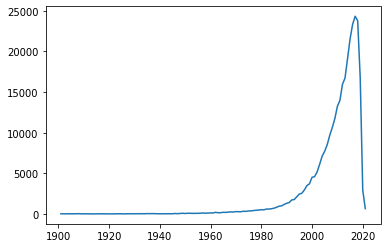

In [86]:
cursor.execute("SELECT p.Pub_Year,COUNT(*)  FROM Papers p  GROUP BY p.Pub_Year")
year_distribution = cursor.fetchall()
year_distribution_sorted = sorted(year_distribution, key=lambda tup: tup[0] if tup[0] else 0)
year = []
year_amount = []
for el in year_distribution_sorted:
    if el[0]:
        if 1900 < el[0] < 2022:
            year.append(el[0])
            year_amount.append(el[1])
plt.plot(sorted(year), year_amount)
plt.show()

In [87]:
year_distribution_sorted

[(None, 14904),
 (114, 1),
 (195, 1),
 (197, 1),
 (201, 1),
 (272, 1),
 (835, 1),
 (943, 1),
 (1000, 2),
 (1007, 2),
 (1016, 1),
 (1024, 1),
 (1030, 1),
 (1035, 1),
 (1037, 1),
 (1038, 4),
 (1043, 1),
 (1056, 1),
 (1067, 1),
 (1075, 1),
 (1087, 1),
 (1104, 1),
 (1109, 4),
 (1110, 1),
 (1112, 2),
 (1114, 1),
 (1165, 1),
 (1204, 1),
 (1206, 1),
 (1215, 1),
 (1222, 1),
 (1232, 1),
 (1259, 1),
 (1272, 1),
 (1301, 1),
 (1305, 1),
 (1310, 1),
 (1311, 1),
 (1312, 2),
 (1361, 2),
 (1365, 1),
 (1377, 1),
 (1401, 1),
 (1405, 1),
 (1407, 1),
 (1409, 5),
 (1411, 3),
 (1412, 3),
 (1424, 1),
 (1434, 1),
 (1449, 1),
 (1451, 1),
 (1480, 1),
 (1482, 2),
 (1490, 1),
 (1503, 1),
 (1505, 1),
 (1506, 1),
 (1507, 1),
 (1512, 2),
 (1524, 2),
 (1528, 1),
 (1531, 1),
 (1541, 1),
 (1545, 1),
 (1559, 1),
 (1569, 1),
 (1579, 1),
 (1602, 1),
 (1603, 1),
 (1606, 2),
 (1607, 1),
 (1615, 1),
 (1687, 1),
 (1694, 1),
 (1703, 1),
 (1704, 1),
 (1709, 1),
 (1712, 1),
 (1714, 1),
 (1719, 1),
 (1750, 1),
 (1759, 1),
 (1760,

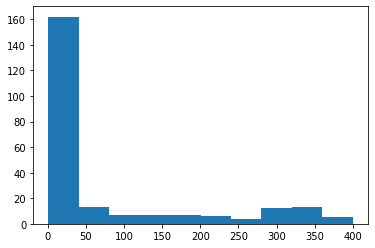

In [77]:
cursor.execute("SELECT p.ReferenceCount,COUNT(*) FROM Papers p WHERE p.ReferenceCount > 0 AND p.Leaf = FALSE GROUP BY p.ReferenceCount")
ref_distribution = cursor.fetchall()
ref_distribution_sorted = sorted(ref_distribution, key=lambda tup: tup[1])
ref = []
ref_amount = []
for el in ref_distribution_sorted:
    if el[0]:
        if el[0] < 1400:
            ref.append(el[0])
            ref_amount.append(el[1])
plt.hist(ref_amount)
plt.show()

In [107]:
cursor.execute("SELECT ReferenceID,ReferencedByID FROM referencedBy r")
references = cursor.fetchall()

In [108]:
references_df = pd.DataFrame(references, columns=["Source", "Target"])

In [109]:
references_df.to_csv("references2.csv", index="False")